In [5]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

import numpy as np

from fealpy.functionspace import LagrangeFESpace as Space
from fealpy.fem import LinearElasticityOperatorIntegrator
from fealpy.fem import BilinearForm
from fealpy.fem import VectorSourceIntegrator
from fealpy.fem import LinearForm

from linear_elasticity_model3d import BoxDomainData3d

pde = BoxDomainData3d()
mu = pde.mu
lambda_ = pde.lam
domain = pde.domain()
#mesh = pde.init_mesh(n=1)

In [6]:
p = 1
GD = 3
doforder = 'vdims'

maxit = 5
errorType = ['$|| Ku - F ||_{L_2}$',
             '$|| uh - u ||_{L_2}$']
errorMatrix = np.zeros((2, maxit), dtype=np.float64)
NDof = np.zeros(maxit, dtype=np.int_)
nx = 2
ny = 2
nz = 2
mesh = pde.init_mesh(nx=nx, ny=ny, nz=nz)

for i in range(maxit):
    space = Space(mesh, p=p, doforder=doforder)

    u_exact = space.interpolate(pde.solution)
    uh = space.function(dim=GD)
    vspace = GD*(space, )
    gdof = vspace[0].number_of_global_dofs()
    vgdof = gdof * GD
    print("vgdof:", vgdof)
    ldof = vspace[0].number_of_local_dofs()
    vldof = ldof * GD
    NDof[i] = vspace[0].number_of_global_dofs()

    integrator1 = LinearElasticityOperatorIntegrator(
                lam=lambda_, mu=mu, q=p+5
                                                    )
    bform = BilinearForm(vspace)
    bform.add_domain_integrator(integrator1)
    KK = integrator1.assembly_cell_matrix(space=vspace)
    K = bform.assembly()

    F_exact = space.interpolate(pde.source)
    F_approx_computed = space.function(dim=GD)
    F_approx_computed.flat[:] = K @ u_exact.flat
   

    integrator3 = VectorSourceIntegrator(f=pde.source, q=p+5)
    lform = LinearForm(vspace)
    lform.add_domain_integrator(integrator3)
    FK = integrator3.assembly_cell_vector(space = vspace)
    F = lform.assembly()
    F_exact_computed = F

    h = nx * 2 ** i
    errorMatrix[0, i] = np.linalg.norm(F_approx_computed.reshape(-1) \
                                       - F_exact_computed, ord=1) / (h ** GD)

    dflag = vspace[0].boundary_interpolate(
        gD=pde.dirichlet, uh=uh,
        threshold=pde.is_dirichlet_boundary)
    ipoints = vspace[0].interpolation_points()
    uh[dflag] = pde.dirichlet(ipoints[dflag])
    
    F -= K@uh.flat
    F[dflag.flat] = uh.ravel()[dflag.flat]

    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1

    uh.flat[:] = spsolve(K, F)

    errorMatrix[1, i] = mesh.error(u=uh, v=u_exact, q=p+5, power=2)
    
    if i < maxit-1:
        mesh.uniform_refine()

print("errorMatrix:\n", errorMatrix)
print("ratio:\n", errorMatrix[:, 0:-1]/errorMatrix[:, 1:])

vgdof: 81
vgdof: 375
vgdof: 2187
vgdof: 14739
vgdof: 107811
errorMatrix:
 [[4.79266827e-02 1.08250104e-02 1.67788006e-03 2.31449086e-04
  3.05571984e-05]
 [6.05153648e-03 9.18573400e-03 1.05132489e-02 1.09464885e-02
  1.10708774e-02]]
ratio:
 [[4.4274029  6.45159966 7.24945643 7.57429013]
 [0.65879727 0.87372934 0.96042204 0.98876432]]


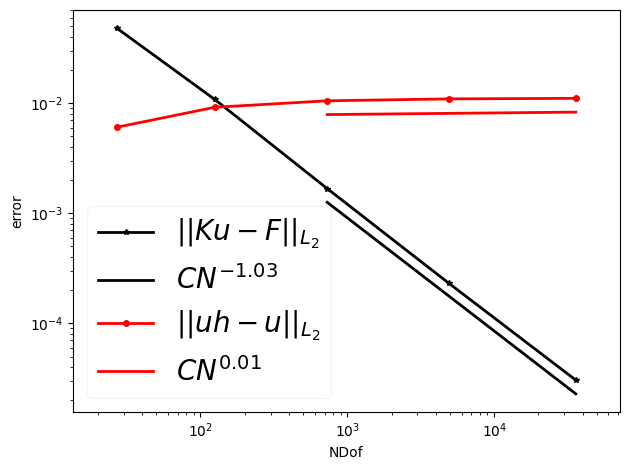

In [7]:
from fealpy.tools.show import showmultirate
import matplotlib.pyplot as plt

showmultirate(plt, 2, NDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.xlabel('NDof')
plt.ylabel('error')
plt.tight_layout()
plt.show()

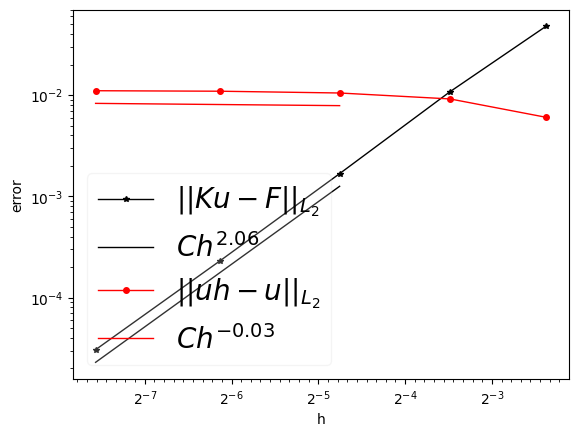

In [8]:
h = 1 / (np.power(NDof, 1/2))     
showmultirate(plt, 2, h, errorMatrix,  errorType, propsize=20)
plt.xlabel('h')
plt.ylabel('error')
plt.show()